In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.linalg as la

## (Andrew's Data so far)

In [42]:
def get_deltas(age_brackets=[18, 40, 65, 85]):
    """
    Helper function that calculates and returns a list of deltas based on birthrate and age brackets.

    Parameters:
    - age_brackets (list): A list of age brackets defining the population segments.

    Returns:
    - list: A list of deltas calculated based on the given birthrate and age brackets.
    """

    # Insert 0 at the beginning of age_brackets to simplify calculations
    M = [0] + age_brackets

    # Calculate deltas based on age brackets
    deltas = [1 / (M[i] - M[i - 1]) for i in range(1, 5)]

    # This is the births delta
    deltas = [.5/(M[2]-M[1])]+deltas

    # Return the modified delta list
    return deltas


In [43]:
def population_SIR(deltas,birthrate = 2):
    """
    Creates a function representing the population dynamics in an SIR (Susceptible-Infectious-Recovered) model.

    Parameters:
    - deltas (list or array): A list or array containing the transition rates between different population compartments.
    - birthrate (int or float or function) The birthrate for the country. Can be constant or a function of time.

    Returns:
    - function: A function representing the population dynamics in the SIR model.
    """

    # Convert deltas to a NumPy array for numerical operations
    d = np.array(deltas)

    def ode(t, n):
        """
        Function representing the rate of change of each population compartment in the SIR model.

        Parameters:
        - t (float): Time parameter (not used in the function, but required for integration).
        - n (array): Array representing the current state of the population compartments.

        Returns:
        - array: Array representing the rate of change of each population compartment.
        """
        DN = np.zeros_like(n)

        # Calculate the rate of change for each compartment based on the SIR model equations
        if callable(birthrate):
            DN[0] = birthrate(t)*d[0] * n[1] - d[1] * n[0]
        else:
            DN[0] = birthrate*d[0] * n[1] - d[1] * n[0]
        DN[1:] = -d[2:] * n[1:] + d[1:-1] * n[:-1]

        return DN
    
    # Return the function representing the population dynamics
    return ode

        

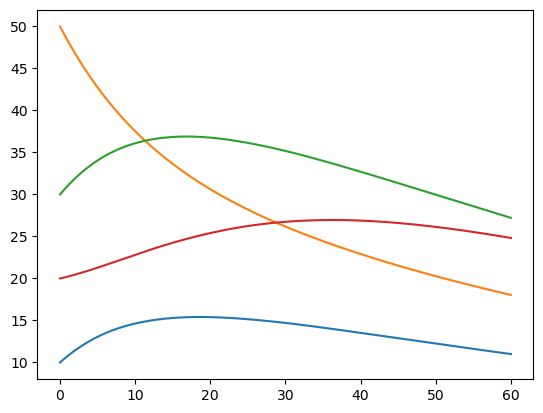

In [50]:
deltas = get_deltas()
ode = population_SIR(deltas,1.2)

ts = np.linspace(0,60,512)
x0 = np.array([10,50,30,20])

sol = solve_ivp(ode,(0,60),x0,t_eval=ts)

plt.plot(sol.t,sol.y.T)

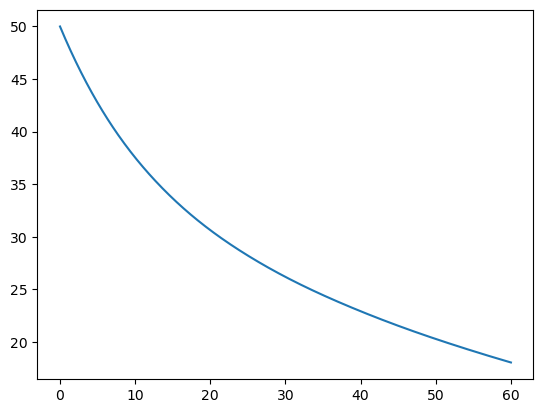

In [53]:
#%run Volume4Project.ipynb

# %store -r sol.y # I think this command will work.

N_matrix = sol.y
N_matrix[0,:]
plt.plot(sol.t, N_matrix[1,:])

## Generational Productivity

In [111]:
# Define constants

# Model for the U.S
alpha = 0.4                            # For developed countries
A = 1                                  # Assume constant technology
delta = 0.037                          # Depreciation rate of capital.
domain = sol.t # Subject to change
k0 = [1]
t_span = (0,60)
lfgr = 0.01
s = 0.4

def n(t):
    if t not in domain: # If the input is not found in the domain, map it to the nearest domain value
        t1 = np.argmin(la.norm(domain-t))
    else:
        t1 = t
    index = np.where(domain == t1)[0]
    return N_matrix[:,index[0]]

n = np.vectorize(n)

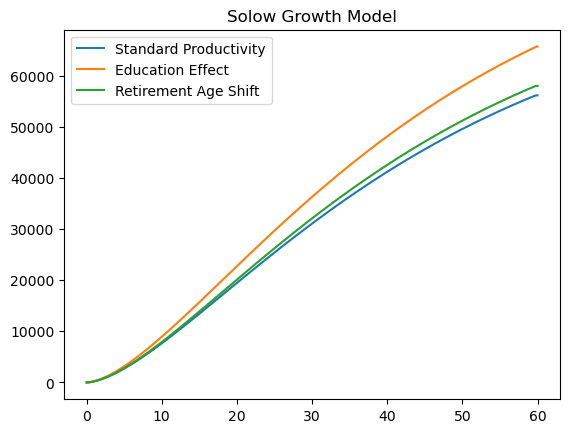

In [112]:
def Solow_productivity(t,k, c = np.array([1,1,1,1])):
    """Models the Solow growth curve, but with the variation that productivity depends on population class
    Parameters:
    t (float) - The time element
    k (callable function) - Capital. This is the dependent variable
    """
    y = A * (k**alpha) * np.dot(c,n(t))
    return s*y - (delta + lfgr)*k

# c represents the workforce productivity of each generation
# NOTE: These choices of c-values are pretty arbitrary. I could do some research to get a more accurate estimate.
# These c-values will not be normalized.
c_list = [np.array([.3, 1, 1.5, .2]), np.array([0, 1.2, 1.6, .2]), np.array([.3, 1, 1.5, .3])]
# This needs to be coupled with population effects.
label_list = ["Standard Productivity", "Education Effect", "Retirement Age Shift"]

for c, label in zip(c_list, label_list):
    k = solve_ivp(Solow_productivity, t_span, k0, t_eval=domain, args=[c,])
    plt.plot(k.t, k.y[0], label=label)


plt.title("Solow Growth Model")
plt.legend()
plt.show()

## Retirement Age Increase

## Retirement Age Decrease

## Generational Saving Habits

In [ ]:
# TODO: This part

def Solow_savings(t,k, c = np.array([1,1,1,1])):
    """Models the Solow growth curve, but with the variation that productivity depends on population class
    Parameters:
    t (float) - The time element
    k (callable function) - Capital. This is the dependent variable
    """
    y = A * (k**alpha) * np.dot(c,n)
    
    return s*y - (delta + lfgr)*k

### Experimenting

In [118]:
%store -r
testString

'This string will hopefully make it to the other notebook'